# Estimating Gentrification using Street View Images and Embeddings

This script (initially produced by ChatGPT) does the following (_this was my query_):
 - Read a spatial boundary file (that I will hard code)
 - Obtain the road network (from OSM?) for that area
 - Generate sample points on the road network roughly X meters apart
 - At each sample point, download the most recent street images for that location (either a single 360 degree view of a few smaller images). Use whichever API service is the most appropriate for obtaining the images. Importantly please record the date that the image was taken.
 - For each image, calculate an embedding using an appropriate foundation model (one that has been pre-trained to distinguish street environments specifically). Please use Hugging Face libraries.
 - If necessary, calculate the mean embedding for each point (is this the best way to calculate a single embedding for a point represented by multiple images?)
 - Now, for each sampled point there will be a dataframe with information about the point and its embedding. Read another polygon spatial data file, that I will provide, which contains area-level estimates of gentrification.
 - Use point-in-polygon to get the gentrification for each point.
 - Use cross-validation to train a couple of ML models (probaly random forest, linear regression and a neural network) to estimate gentrification from the embedding vectors
 - Choose the best model and parameter configuration and test this model on some held-out data.

## Configuration and library loading

In [22]:
import os
os.environ["HF_HOME"] = "/nfs/a319/gy17m2a/scratch/hf_cache"
import random
import pickle
import geopandas as gpd
from shapely.geometry import Point, LineString
import numpy as np
import osmnx as ox
import torch
from PIL import Image
import matplotlib.pyplot as plt
from concurrent.futures import ThreadPoolExecutor, as_completed
from tqdm import tqdm
from scipy.stats import entropy

# # Hugging Face Transformers for image embedding
from transformers import AutoImageProcessor, AutoModel, ViTModel, ViTImageProcessor, ViTConfig

# # ----------------- Configuration -----------------
# #np.random.seed(42)
# density_per_km = 0.3  # number of points to sample per km of road
# #density_per_km = 0.1  # VERY FEW WHILE TESTING
DOWNLOAD_IMAGES = False  # If false then don't download any images, just load those that have been cached

data_dir = os.path.join("../../data/embeddings/")
boundary_file = os.path.join(data_dir, "greater_manchester_lsoas.geojson")  # Path to boundary polygon file
lsoas_file = os.path.join("../../data/SpatialData/", "LSOAs_2021", "LSOA_2021_EW_BSC_V4.shp")
n_directions = 4         # number of street view images per point (e.g., 4 cardinal directions)

## Data Loading

In [23]:
# --- Load neighbourhood polygons and dissolve to one study-area boundary ---
boundary_neighs = gpd.read_file(boundary_file)
# Make sure we're in WGS84 (lat/lon) for OSM and APIs
boundary_neighs = boundary_neighs.to_crs(epsg=4326)
# Dissolve: merge all geometries into one polygon (MultiPolygon possible)
boundary_polygon = boundary_neighs.union_all()  # shapely (multi)polygon
boundary_gdf = gpd.GeoDataFrame(data={'name': ['study_area']},
    geometry=[boundary_polygon], crs=boundary_neighs.crs)
print("Merged neighbourhoods into single study-area boundary.")
print("Bounds:", boundary_polygon.bounds)
# boundary_gdf.plot(color='lightblue', edgecolor='black')

Merged neighbourhoods into single study-area boundary.
Bounds: (-2.73052481406758, 53.3281053809015, -1.90962093258169, 53.6857339236763)


## Read the LSOA boundary data

(later it will be joined to the Greater Manchester Gentrification Index and IMD)

In [24]:
lsoas =  gpd.read_file(lsoas_file)
manc_lads = ['Manchester', 'Rochdale', 'Bolton', 'Bury', 'Wigan', 'Oldham',  'Trafford', 'Salford', 'Tameside', 'Stockport']
manc_lads_pattern = '|'.join(manc_lads)
gm_lsoa=lsoas[lsoas['LSOA21NM'].str.contains(manc_lads_pattern)]
gm_lsoa = gm_lsoa.to_crs(epsg=4326)
# gm_lsoa.plot()

### Load list of sample points

In [25]:
# Cache file for the entire points data with embeddings (images are stored separately)
DEBUG = False
points_data_cache = data_dir + "sample_points_cache/points_data_cache_with_embeddings.pkl"

# -----------------------------------------------------------
# Load existing cache so we can *append* new sample points
# -----------------------------------------------------------
if os.path.isfile(points_data_cache):
    print("Loading cached point data …")
    with open(points_data_cache, "rb") as f:
        point_records = pickle.load(f)
    existing_coords = {(rec["latitude"], rec["longitude"]) for rec in point_records}
    next_id = max(rec["point_id"] for rec in point_records) + 1
else:
    point_records = []
    existing_coords = set()
    next_id = 0

print(f"Cache currently has {len(point_records)} points.")
added_this_run = 0

Loading cached point data …
Cache currently has 18897 points.


### Map of the full sample (cache + any others just downlaoded)

In [ ]:
# if point_records:    
#     fig, ax = plt.subplots(figsize=(8, 8))

#     # Plot roads first (thin gray lines)
#     # edges_gdf.plot(ax=ax, linewidth=0.1, color="gray")

#     # Plot the sample points
#     gpd.GeoDataFrame(point_records, 
#                      geometry=[Point(rec["longitude"], rec["latitude"]) for rec in point_records], 
#                      crs="EPSG:4326").plot(ax=ax, color="blue", markersize=0.2, label="Sample Points")

#     # Plot the study-area outline on top (thicker red line)
#     boundary_gdf.boundary.plot(ax=ax, linewidth=2, edgecolor="red")

#     ax.set_title("Road network & study-area boundary", pad=12)
#     ax.set_axis_off()          # hides lat/lon ticks for a cleaner look
#     ax.set_aspect("equal")     # keeps the map from looking stretched

#     plt.show()

## Compute the Embeddings

(Note: would like to use Places365 but not available in Hugging Face yet, so using ViT base model instead)

In [21]:
# Load model
model_name = "google/vit-base-patch16-224-in21k"
processor = AutoImageProcessor.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name, output_attentions=True).eval()
device = torch.device("cpu")
model.to(device)

config = ViTConfig.from_pretrained(model_name, output_attentions=True)
model = AutoModel.from_pretrained(model_name, config=config).eval()

# Directory for saving heatmaps
heatmap_dir = "../../data/embeddings/saliency_heatmaps_new"
os.makedirs(heatmap_dir, exist_ok=True)

def generate_attention_map_rollout(img_path):
    """Return embedding and rolled-out attention map for a single image."""
    img = Image.open(img_path).convert("RGB")
    inputs = processor(img, return_tensors="pt", size=224).to(device)

    with torch.no_grad():
        outputs = model(**inputs, output_attentions=True)
        attentions = outputs.attentions  # list of (batch, heads, tokens, tokens)

    # --- Get number of tokens ---
    tokens = attentions[0].size(-1)
    n_patches = tokens - 1
    side = int(np.sqrt(n_patches))
    if side * side != n_patches:
        raise ValueError(f"Patch tokens ({n_patches}) not a perfect square – can't reshape to grid.")

    # --- Initialize rollout ---
    rollout = torch.eye(tokens).to(device)

    for attn in attentions:
        # Remove batch dimension
        attn = attn[0]  # shape (heads, tokens, tokens)
        # Mean over heads
        attn_mean = attn.mean(dim=0)  # shape (tokens, tokens)
        # Add residual connection
        attn_mean = attn_mean + torch.eye(tokens).to(device)
        # Normalize rows
        attn_mean = attn_mean / attn_mean.sum(dim=-1, keepdim=True)
        # Multiply cumulatively
        rollout = torch.matmul(attn_mean, rollout)

    # --- Extract CLS attention to patches ---
    cls_attn = rollout[0, 1:].reshape(side, side).cpu().numpy()

    # --- Normalize for visualization ---
    attn_norm = (cls_attn - cls_attn.min()) / (cls_attn.max() - cls_attn.min())

    # --- Get CLS embedding ---
    cls_embedding = outputs.last_hidden_state[0, 0, :].cpu().numpy()

    return cls_embedding, attn_norm



def generate_attention_map(img_path, layer=11):
    """Return embedding and attention map for a single image."""
    img = Image.open(img_path).convert("RGB")
    inputs = processor(img, return_tensors="pt", size=224).to(device)

    with torch.no_grad():
        outputs = model(**inputs, output_attentions=True)

    cls_embedding = outputs.last_hidden_state[0, 0, :].cpu().numpy()

    # Attention tensor: (num_layers, batch, num_heads, tokens, tokens)
    attn = outputs.attentions[layer][0]  # take selected layer, first batch
    attn_cls = attn[:, 0, 1:]  # attention from [CLS] to all other patches
    attn_mean = attn_cls.mean(0).reshape(14, 14).cpu().numpy()  # 14x14 patches

    # Normalize
    attn_norm = (attn_mean - attn_mean.min()) / (attn_mean.max() - attn_mean.min())

    return cls_embedding, attn_norm


def save_and_show_heatmap(img_path, attn_map, plot=False, ax=False):
    """Overlay attention heatmap on original image, save, and display inline."""
    img = Image.open(img_path).convert("RGB").resize((224, 224))

    # Resize attention map to match image size
    attn_resized = np.array(
        Image.fromarray((attn_map * 255).astype(np.uint8)).resize((224, 224)))
    attn_colored = plt.cm.jet(attn_resized / 255.0)[..., :3]

    # Overlay attention on the image
    overlay = 0.6 * np.array(img) / 255.0 + 0.4 * attn_colored
    overlay = np.clip(overlay, 0, 1)

    # Save to file
    base = os.path.basename(img_path).replace("/", "_")
    out_path = os.path.join(heatmap_dir, f"attn_{base}.png")
    plt.imsave(out_path, overlay)

    # --- Show inline ---
    if plot==True:
        ax.imshow(overlay)
        ax.axis("off")
        #ax.set_title(f"Attention rollout: {os.path.basename(img_path)}")

    return out_path



def embed_image_with_saliency(img_path, plot=False, ax= False):
    """Compute embedding + attention stats + heatmap."""
#     cls_embedding, attn_map = generate_attention_map(img_path)
    cls_embedding, attn_map = generate_attention_map_rollout(img_path)
    
    # Save and display
    heatmap_path = save_and_show_heatmap(img_path, attn_map, plot, ax)

    # Stats of attention
    stats = {
        "mean": float(attn_map.mean()),
        "std": float(attn_map.std()),
        "entropy": float(-np.sum(attn_map * np.log(attn_map + 1e-9))),}
    
    cy, cx = np.unravel_index(attn_map.argmax(), attn_map.shape)
    stats["max_y"], stats["max_x"] = cy, cx

    return cls_embedding, stats, heatmap_path

# ------------------ Embed all images ------------------
already_have_embedding = 0

for rec in tqdm(point_records, desc="Embedding points", unit="point"):
    rec["embeddings"] = []
    rec["attn_stats"] = []
    rec["heatmap_paths"] = []

    for img_path in rec["image_files"]:
        img_path = img_path.replace("airbnb-manchester/", "embeddings/").replace("../", "../../")

        if not os.path.exists(img_path):
            continue

        try:
            embedding, attn_stats, heatmap_path = embed_image_with_saliency(img_path)

            rec["embeddings"].append(embedding)
            rec["attn_stats"].append(attn_stats)
            rec["heatmap_paths"].append(heatmap_path)

        except Exception as e:
            tqdm.write(f"⚠️ Error processing {img_path}: {e}")


# Summary
print(f"\n✅ Created {len(point_records)-already_have_embedding} new embeddings. "
      f"{already_have_embedding} points had existing embeddings.")

# Cache
points_data_cache_with_embeddings = data_dir+"sample_points_cache/points_data_cache_with_embeddings_and_attn_stats_new.pkl"
with open(points_data_cache_with_embeddings, "wb") as f:
    pickle.dump(point_records, f)

print(f"💾 {len(point_records)} embeddings computed and cached.")


In [20]:
points_data_cache_with_embeddings = data_dir+"sample_points_cache/points_data_cache_with_embeddings_and_attn_stats_new.pkl"
with open(points_data_cache_with_embeddings, "wb") as f:
    pickle.dump(point_records, f)

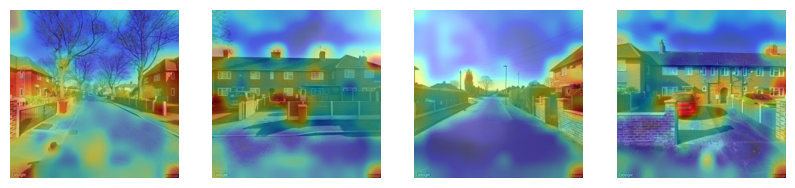

In [14]:
rec= point_records[5]
fig,axs=plt.subplots(ncols=4, figsize=(10,5))
for i in range(0,4):
    img_path = rec["image_files"][i]
    img_path = img_path.replace("airbnb-manchester/", "embeddings/").replace("../", "../../")
    embedding, attn_stats, heatmap_path = embed_image_with_saliency(img_path, plot=True, ax=axs[i])

In [26]:
# Check all records have an embeding
invalid_records = [rec for rec in point_records if rec.get('embedding') is None]
assert len(invalid_records)==0, f"Found {len(invalid_records)} invalid points"